This notebook is for exporting the individual yearly EAZ geojson files as a single geojson file with the year as a column.

In [2]:
import os
import geopandas as gpd
import pandas as pd

In [3]:
# overlaying 2010-era census tracts to 2020-era
original_geom = gpd.read_file("../gis/equity_analysis_zones_2019.geojson")
new_geom = gpd.read_file("../gis/equity_analysis_zones_2020.geojson")
lookup = pd.read_csv("2019_to_2020.csv")

In [32]:
# writing to app folder for 2020 geometry
reduced = new_geom.to_crs(epsg=2277)
reduced['geometry'] = reduced['geometry'].simplify(tolerance=250, preserve_topology=True)
# reduced = new_geom.to_crs(epsg=4326)

In [33]:
reduced.explore()

In [34]:
reduced[["GEOID", "geometry"]].to_file("../maps/census_tract_geometry.geojson")

In [3]:
cols = [
    "2019_tract",
    "indexed_vulnerability",
    "eaz_type",
    "pct_poc",
    "pct_underserved_poc",
    "median_hh_inc",
    "pct_food_stamps",
    "pct_rent_over35",
    "pct_wo_broadband",
    "pct_less_vehicles",
    "pct_with_disability",
    "pct_over_70"
]
original_geom.rename(columns={"GEOID": "2019_tract"}, inplace=True)

In [4]:
lookup["2019_tract"] = lookup["2019_tract"].astype(str)
lookup["2020_tract"] = lookup["2020_tract"].astype(str)
new_geom = new_geom.merge(lookup[["2019_tract", "2020_tract"]], left_on="GEOID", right_on="2020_tract", how="left")
gdf = new_geom[["GEOID", "2019_tract", "NAME", "geometry"]].merge(original_geom[cols], on="2019_tract", how="left")

In [5]:
gdf["acs_year"] = 2019

In [6]:
years = [2020, 2021, 2022]

data = [gdf]
for y in years:
    yr = gpd.read_file(f"../gis/equity_analysis_zones_{y}.geojson")
    yr["acs_year"] = y
    yr = yr.merge(gdf[["GEOID", "indexed_vulnerability"]],on="GEOID", how="left", suffixes=("","_before"))
    yr["difference_since_2019"] = yr["indexed_vulnerability"] - yr["indexed_vulnerability_before"]
    yr.drop("indexed_vulnerability_before", axis=1, inplace=True)
    data.append(yr)
gdf = pd.concat(data)

In [12]:
gdf.drop(columns=["geometry"]).to_csv("../maps/atx_eaz_multi_year.csv", index=False)

In [7]:
gdf.to_file("atx_eaz_multi_year.geojson")

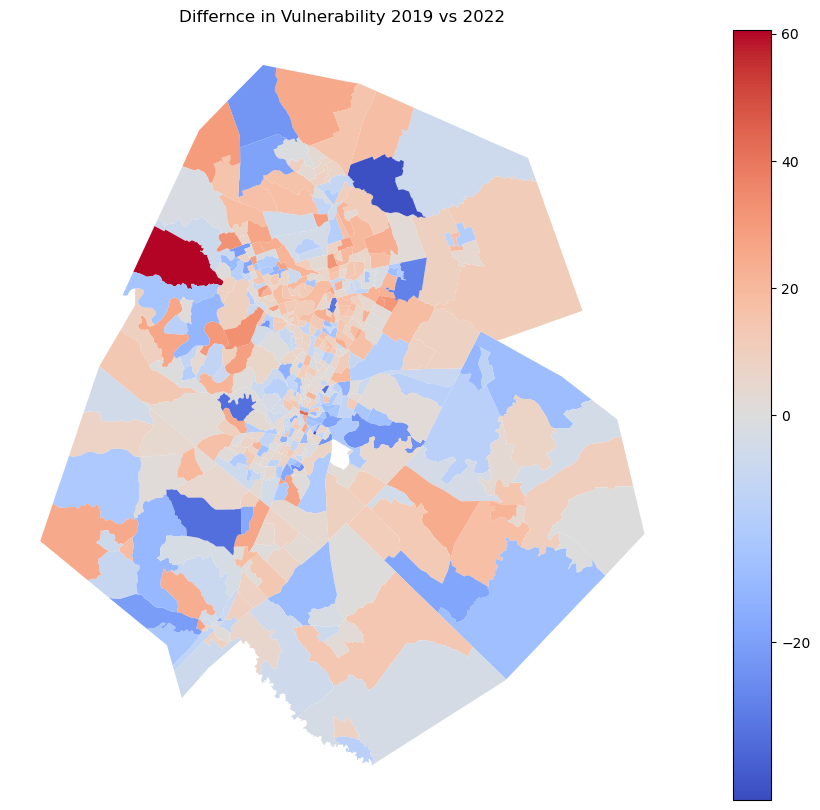

In [8]:
gdf = gdf[gdf["acs_year"] == 2022]

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the min, mid, and max values for the color scale
vmin = gdf["difference_since_2019"].min()
vmax = gdf["difference_since_2019"].max()
vcenter = 0

# Define colormap
cmap = plt.get_cmap('coolwarm')  

# Define the normalization
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column="difference_since_2019", cmap=cmap, norm=norm, ax=ax,  legend=True)

plt.title(f"Differnce in Vulnerability {2019} vs {2022}")
ax.set_axis_off()
plt.show()